✅ Raw dataset: (4000, 51)
✅ Split: (3200, 53) (800, 53)
✅ Encoded shapes: (3200, 3297) (800, 3297)
✅ XGBoost Regressor trained.


C:\Users\dell\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



📊 Evaluation (Regression)
R²   : 0.603
MAE  : 0.129
RMSE : 0.160


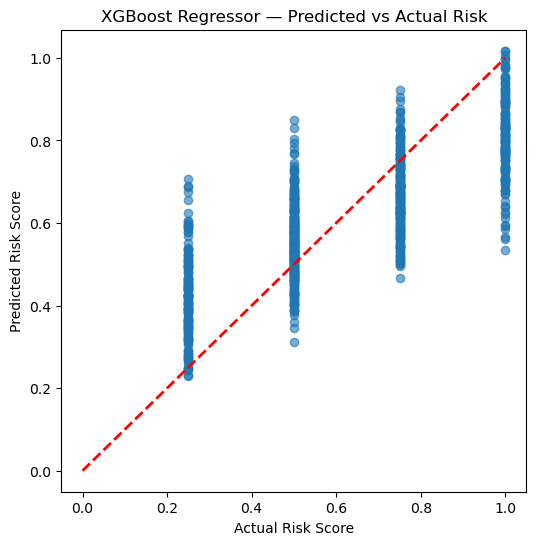


🎯 Sample predictions:
  Actual_Label  Actual_Score  Pred_Score Pred_Label
0          Low          0.25    0.400993     Medium
1         High          0.75    0.570280       High
2          Low          0.25    0.537858       High
3     Critical          1.00    0.798320   Critical
4         High          0.75    0.651519       High
5         High          0.75    0.869321   Critical
6       Medium          0.50    0.726457       High
7         High          0.75    0.754919   Critical
8         High          0.75    0.848617   Critical
9       Medium          0.50    0.633417       High
Saved model (raw json): ../notebooks/models/xgb_reg_raw.json
Saved booster (raw json): ../notebooks/models/xgb_reg_booster_raw.json
Saved input columns: ../notebooks/models/regressor_input_columns.pkl


In [24]:
# ================================================================
# 05_xgboost_regressor_experiment.ipynb  — CLEAN VERSION
# ================================================================

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

DATA_PATH     = "../data/project_risk_raw_dataset.csv"
MODEL_DIR     = "../notebooks/models"
REG_MODEL_PKL = f"{MODEL_DIR}/xgboost_regressor.pkl"
REG_COLS_PKL  = f"{MODEL_DIR}/regressor_input_columns.pkl"

# ---------- 1) Helpers: normalise inputs + feature engineering ----------
LMH_MAP = {'Low': 3, 'Medium': 5, 'High': 8}

def normalize_inputs(df: pd.DataFrame) -> pd.DataFrame:
    """
    - Map 'Low/Medium/High' to numeric for key columns
    - Strip thousand separators and coerce numerics for budget/count/time cols
    """
    df = df.copy()

    # Columns that may appear as L/M/H but we need numeric for FE
    lmh_cols = ['Integration_Complexity', 'Requirement_Stability', 'Market_Volatility']
    for c in lmh_cols:
        if c in df.columns:
            if df[c].dtype == 'object':
                # map L/M/H if present; else try to parse numeric strings
                s = df[c].astype(str).str.strip()
                mapped = s.map(LMH_MAP)
                numeric = pd.to_numeric(s.str.replace(',', ''), errors='coerce')
                df[c] = mapped.fillna(numeric)

    # Columns that should be numeric (may have commas)
    numeric_cols = ['Project_Budget_USD', 'Team_Size', 'Estimated_Timeline_Months', 'Stakeholder_Count']
    for c in numeric_cols:
        if c in df.columns and df[c].dtype == 'object':
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', ''), errors='coerce')

    return df

def feature_engineer(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if {'Project_Budget_USD','Team_Size'}.issubset(df.columns):
        df['Budget_Per_TeamMember'] = df['Project_Budget_USD'] / (df['Team_Size'] + 1e-5)
    if {'Estimated_Timeline_Months','Stakeholder_Count'}.issubset(df.columns):
        df['Schedule_Pressure_Index'] = df['Estimated_Timeline_Months'] / (df['Stakeholder_Count'] + 1e-5)
    if {'Integration_Complexity','Requirement_Stability','Market_Volatility'}.issubset(df.columns):
        df['Complexity_Index'] = (
            df['Integration_Complexity'].astype(float)
            + df['Requirement_Stability'].astype(float)
            + df['Market_Volatility'].astype(float)
        ) / 3.0
    return df

# ---------- 2) Load and prepare data ----------
df = pd.read_csv(DATA_PATH)
print("✅ Raw dataset:", df.shape)

# Make sure Risk_Level exists
assert 'Risk_Level' in df.columns, "Risk_Level column not found."

# Normalise key inputs required by FE (prevents float+str errors)
df = normalize_inputs(df)
# Now derive FE columns
df = feature_engineer(df)

# Split features/target
X = df.drop(columns=['Risk_Level'])
y_labels = df['Risk_Level']  # keep original labels for mapping

# Train/Test split
X_train_raw, X_test_raw, y_train_labels, y_test_labels = train_test_split(
    X, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)
print("✅ Split:", X_train_raw.shape, X_test_raw.shape)

# Map labels → continuous scores for regression target
label_to_score = {'Low': 0.25, 'Medium': 0.50, 'High': 0.75, 'Critical': 1.00}
y_train = y_train_labels.map(label_to_score)
y_test  = y_test_labels.map(label_to_score)

# One-hot encode X, align test to train columns
X_train = pd.get_dummies(X_train_raw, drop_first=True)
X_test  = pd.get_dummies(X_test_raw, drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

print("✅ Encoded shapes:", X_train.shape, X_test.shape)

# ---------- 3) Train regressor ----------
xgb_reg = XGBRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
    objective='reg:squarederror'
)
xgb_reg.fit(X_train, y_train)
print("✅ XGBoost Regressor trained.")

# ---------- 4) Evaluate ----------
y_pred = xgb_reg.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("\n📊 Evaluation (Regression)")
print(f"R²   : {r2:.3f}")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")

# ---------- 5) Visual check ----------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0,1],[0,1],'r--', lw=2)
plt.xlabel("Actual Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("XGBoost Regressor — Predicted vs Actual Risk")
plt.show()

# Optional label view
def score_to_label(s: float) -> str:
    if s < 0.25: return "Low"
    elif s < 0.50: return "Medium"
    elif s < 0.75: return "High"
    else: return "Critical"

preview = pd.DataFrame({
    "Actual_Label": y_test_labels.values,
    "Actual_Score": y_test.values,
    "Pred_Score":  y_pred,
    "Pred_Label":  pd.Series(y_pred).apply(score_to_label).values
})
print("\n🎯 Sample predictions:")
print(preview.head(10))

# ---------- 6) Save model + columns ----------
#joblib.dump(xgb_reg, REG_MODEL_PKL)
#joblib.dump(list(X_train.columns), REG_COLS_PKL)
# ---------- 6) Save model + columns ----------

# # 1. Save Input Columns (safe)
# joblib.dump(list(X_train.columns), REG_COLS_PKL)

# # 2. Save model using XGBoost's native stable format
# JSON_MODEL_PATH = f"{MODEL_DIR}/xgboost_regressor.json"
# xgb_reg.save_model(JSON_MODEL_PATH)

# # 3. Also save Booster inside joblib (secondary backup)
# booster = xgb_reg.get_booster()
# PKL_MODEL_PATH = f"{MODEL_DIR}/xgboost_regressor_booster.pkl"
# joblib.dump(booster, PKL_MODEL_PATH)

# print("\n💾 Saved model (JSON) →", JSON_MODEL_PATH)
# print("💾 Saved model (Booster-PKL) →", PKL_MODEL_PATH)
# print("💾 Saved input columns →", REG_COLS_PKL)

# ---------- 6) Save model + columns (text-safe version) ----------

# 1. Save columns normally (this works)
joblib.dump(list(X_train.columns), REG_COLS_PKL)

# 2. Save model in raw JSON text (never corrupts)
JSON_MODEL_PATH = f"{MODEL_DIR}/xgb_reg_raw.json"
xgb_reg.save_model(JSON_MODEL_PATH)

# 3. ALSO save booster in JSON (backup)
BOOSTER_JSON_PATH = f"{MODEL_DIR}/xgb_reg_booster_raw.json"
xgb_reg.get_booster().save_model(BOOSTER_JSON_PATH)

print("Saved model (raw json):", JSON_MODEL_PATH)
print("Saved booster (raw json):", BOOSTER_JSON_PATH)
print("Saved input columns:", REG_COLS_PKL)





# print(f"\n💾 Saved model → {REG_MODEL_PKL}")
# print(f"💾 Saved input columns → {REG_COLS_PKL}")


In [25]:
booster = xgb_reg.get_booster()
booster.save_model("xgb_reg_booster_raw.model")


C:\Users\dell\AppData\Local\Temp\ipykernel_11620\581969436.py:2: UserWarning: [20:09:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  booster.save_model("xgb_reg_booster_raw.model")


In [26]:
# ========================================
# compute threashold 
# ========================================

import numpy as np
import pandas as pd

# 1) Load dataset
df = pd.read_csv("../data/project_risk_raw_dataset.csv")

# 2) Preprocess (reuse same functions)
df_clean = normalize_inputs(df)
df_clean = feature_engineer(df_clean)

# 3) Remove target
X = df_clean.drop(columns=["Risk_Level"])

# 4) One-hot encode + align
X_enc = pd.get_dummies(X, drop_first=True)
X_enc = X_enc.reindex(columns=X_train.columns, fill_value=0)

# 5) Predict on full dataset
scores = xgb_reg.predict(X_enc)

# 6) Compute thresholds
t25 = np.percentile(scores, 25)
t50 = np.percentile(scores, 50)
t75 = np.percentile(scores, 75)

print("25th percentile (Low→Medium):", t25)
print("50th percentile (Medium→High):", t50)
print("75th percentile (High→Critical):", t75)

# Optionally save JSON
import json
with open("global_thresholds.json", "w") as f:
    json.dump({
        "low_medium": float(t25),
        "medium_high": float(t50),
        "high_critical": float(t75)
    }, f, indent=4)

print("\nSaved global_thresholds.json")


25th percentile (Low→Medium): 0.4981968104839325
50th percentile (Medium→High): 0.518235981464386
75th percentile (High→Critical): 0.750578984618187

Saved global_thresholds.json


In [21]:
# --- New: F1 for Labels (Using Globals) ---
import json
from sklearn.metrics import f1_score
import numpy as np

# Load globals
with open('global_thresholds.json', 'r') as f:
    T = json.load(f)

def convert_to_class(scores):
    return np.where(scores < T['low_medium'], 0,
                   np.where(scores < T['medium_high'], 1,
                           np.where(scores < T['high_critical'], 2, 3)))

# Map test labels to ints (Low=0, etc.)
label_to_int = {'Low': 0, 'Medium': 1, 'High': 2, 'Critical': 3}
y_test_int = y_test_labels.map(label_to_int)

# Convert preds to classes
y_pred_class = convert_to_class(y_pred)

# Compute F1 (weighted for imbalance)
baseline_f1 = f1_score(y_test_int, y_pred_class, average='weighted')
print(f"\n🎯 Baseline F1 Score: {baseline_f1:.4f}")
print("Globals Used:", T)  # Quick check


🎯 Baseline F1 Score: 0.4459
Globals Used: {'low_medium': 0.4981968104839325, 'medium_high': 0.518235981464386, 'high_critical': 0.750578984618187}


Thresholds:
25th: 0.4976356327533722
50th: 0.5967679917812347
75th: 0.7215921729803085


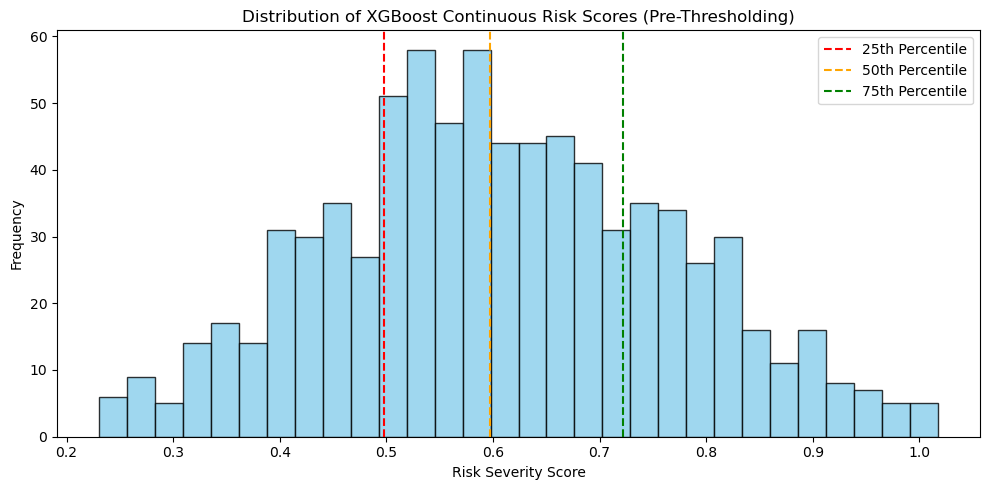

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Use the test-set predictions
# -------------------------------
scores = np.array(y_pred)    # <- correct variable from your notebook

# -------------------------------
# 2. Compute global thresholds
# -------------------------------
t25 = np.percentile(scores, 25)
t50 = np.percentile(scores, 50)
t75 = np.percentile(scores, 75)

print("Thresholds:")
print("25th:", t25)
print("50th:", t50)
print("75th:", t75)

# -------------------------------
# 3. Plot histogram
# -------------------------------
plt.figure(figsize=(10,5))
plt.hist(scores, bins=30, color='skyblue', edgecolor='black', alpha=0.8)

plt.axvline(t25, color='red', linestyle='--', label="25th Percentile")
plt.axvline(t50, color='orange', linestyle='--', label="50th Percentile")
plt.axvline(t75, color='green', linestyle='--', label="75th Percentile")

plt.title("Distribution of XGBoost Continuous Risk Scores (Pre-Thresholding)")
plt.xlabel("Risk Severity Score")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("xgboost_histogram.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()


In [29]:
plt.savefig("xgboost_score_distribution.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

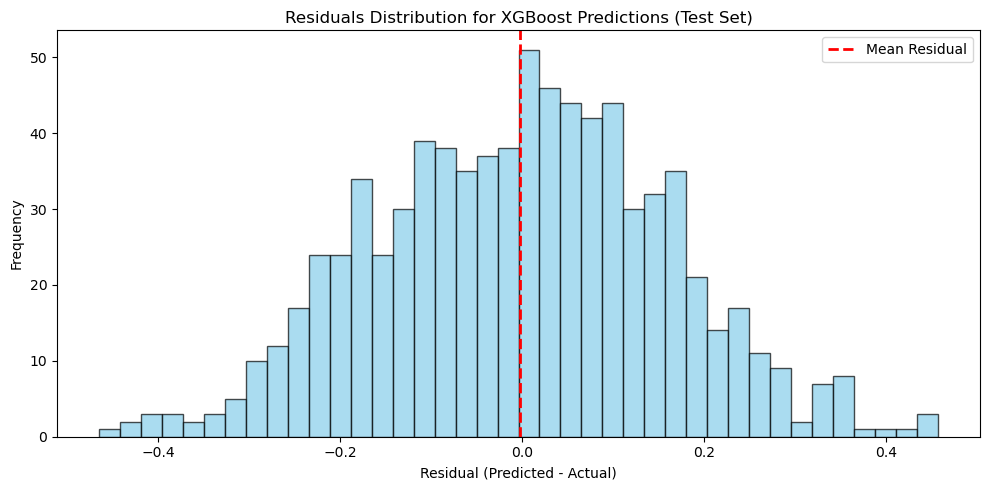

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Compute residuals
residuals = y_pred - y_test

plt.figure(figsize=(10,5))
plt.hist(residuals, bins=40, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(residuals), color='red', linestyle='--', linewidth=2, label='Mean Residual')

plt.title("Residuals Distribution for XGBoost Predictions (Test Set)")
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(False)
plt.savefig("xgboost_histogram Test Set Residual.png", dpi=300, bbox_inches="tight")
plt.tight_layout()

plt.show()


C:\Users\dell\AppData\Local\Temp\ipykernel_11620\980652606.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


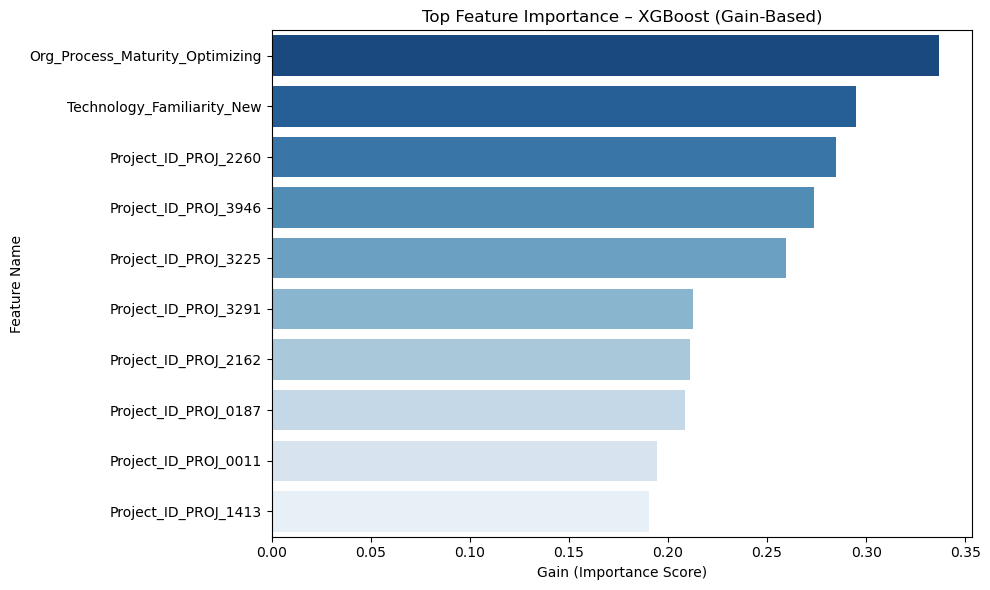

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. Extract Feature Importance (Gain)
# ---------------------------------------------------------
booster = xgb_reg.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Convert to DataFrame
importance_df = (
    pd.DataFrame([
        {"Feature": k, "Gain": v} for k, v in importance_dict.items()
    ])
    .sort_values("Gain", ascending=False)
    .reset_index(drop=True)
)

# ---------------------------------------------------------
# 2. Select Top 10 Features
# ---------------------------------------------------------
top10 = importance_df.head(10)

# ---------------------------------------------------------
# 3. Plot Horizontal Bar Chart
# ---------------------------------------------------------
plt.figure(figsize=(10,6))
sns.barplot(
    data=top10,
    x="Gain",
    y="Feature",
    palette="Blues_r"
)
plt.xlabel("Gain (Importance Score)")
plt.ylabel("Feature Name")
plt.title("Top Feature Importance – XGBoost (Gain-Based)")
plt.tight_layout()

# Save figure
plt.savefig("feature_importance_top10.png", dpi=300)
plt.show()


In [37]:
print(df.columns.tolist())


['Project_ID', 'Project_Type', 'Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Methodology_Used', 'Team_Experience_Level', 'Past_Similar_Projects', 'External_Dependencies_Count', 'Change_Request_Frequency', 'Project_Phase', 'Requirement_Stability', 'Team_Turnover_Rate', 'Vendor_Reliability_Score', 'Historical_Risk_Incidents', 'Communication_Frequency', 'Regulatory_Compliance_Level', 'Technology_Familiarity', 'Geographical_Distribution', 'Stakeholder_Engagement_Level', 'Schedule_Pressure', 'Budget_Utilization_Rate', 'Executive_Sponsorship', 'Funding_Source', 'Market_Volatility', 'Integration_Complexity', 'Resource_Availability', 'Priority_Level', 'Organizational_Change_Frequency', 'Cross_Functional_Dependencies', 'Previous_Delivery_Success_Rate', 'Technical_Debt_Level', 'Project_Manager_Experience', 'Org_Process_Maturity', 'Data_Security_Requirements', 'Key_Stakeholder_Availability', 'Tech_Environment_Stability', 'Contract_Type',

In [38]:
print(X_train.columns[:50].tolist())


['Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Past_Similar_Projects', 'External_Dependencies_Count', 'Change_Request_Frequency', 'Requirement_Stability', 'Team_Turnover_Rate', 'Vendor_Reliability_Score', 'Historical_Risk_Incidents', 'Communication_Frequency', 'Geographical_Distribution', 'Schedule_Pressure', 'Budget_Utilization_Rate', 'Market_Volatility', 'Integration_Complexity', 'Resource_Availability', 'Organizational_Change_Frequency', 'Cross_Functional_Dependencies', 'Previous_Delivery_Success_Rate', 'Technical_Debt_Level', 'Project_Start_Month', 'Current_Phase_Duration_Months', 'Seasonal_Risk_Factor', 'Budget_Per_TeamMember', 'Schedule_Pressure_Index', 'Complexity_Index', 'Project_ID_PROJ_0002', 'Project_ID_PROJ_0003', 'Project_ID_PROJ_0004', 'Project_ID_PROJ_0006', 'Project_ID_PROJ_0007', 'Project_ID_PROJ_0010', 'Project_ID_PROJ_0011', 'Project_ID_PROJ_0013', 'Project_ID_PROJ_0014', 'Project_ID_PROJ_0019', 'Project_ID_

In [20]:
# # --- Improved: Prune to Top 200 Features (with NaN Fix) ---
# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.impute import SimpleImputer

# # Step 1: Impute NaNs (median—practical for numerics)
# imputer = SimpleImputer(strategy='median')  # Or 'mean' if you prefer
# X_train_imputed = imputer.fit_transform(X_train)
# X_test_imputed = imputer.transform(X_test)

# # Step 2: Now prune (safe on clean data)
# selector = SelectKBest(score_func=f_regression, k=200)
# X_train_sel = selector.fit_transform(X_train_imputed, y_train)
# X_test_sel = selector.transform(X_test_imputed)

# # Step 3: Retrain on selected feats
# xgb_reg_pruned = XGBRegressor(  # Reuse your baseline params
#     n_estimators=400, learning_rate=0.1, max_depth=8,
#     subsample=0.8, colsample_bytree=0.6, random_state=42,
#     objective='reg:squarederror'
# )
# xgb_reg_pruned.fit(X_train_sel, y_train)

# # Step 4: Predict & F1 (reuse convert_to_class from F1 cell)
# y_pred_sel = xgb_reg_pruned.predict(X_test_sel)
# y_pred_sel_class = convert_to_class(y_pred_sel)  # From your F1 def
# pruned_f1 = f1_score(y_test_int, y_pred_sel_class, average='weighted')  # y_test_int from F1

# # Compare
# print(f"Pruned F1: {pruned_f1:.4f} (vs. Baseline {baseline_f1:.4f})")  # baseline_f1 from F1 cell
# print(f"Feats Reduced: {X_train.shape[1]} → {X_train_sel.shape[1]}")
# print(f"NaNs Imputed: Train {np.isnan(X_train).sum()} → 0")  # Quick check

C:\Users\dell\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Requirement_Stability' 'Complexity_Index']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\dell\anaconda3\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['Requirement_Stability' 'Complexity_Index']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Pruned F1: 0.4316 (vs. Baseline 0.4459)
Feats Reduced: 3297 → 200
NaNs Imputed: Train Team_Size                              0
Project_Budget_USD                     0
Estimated_Timeline_Months              0
Complexity_Score                       0
Stakeholder_Count                      0
                                      ..
Team_Colocation_Hybrid                 0
Team_Colocation_Partially Colocated    0
Documentation_Quality_Excellent        0
Documentation_Quality_Good             0
Documentation_Quality_Poor             0
Length: 3297, dtype: int64 → 0


In [9]:
# # ========================================
# # To test regression-based approach (XGBoost Regressor) for predicting project risk score and compare 
# # its performance with classification models.
# # ========================================

# # ================================================================
# # 05_xgboost_regressor_experiment.ipynb
# # Purpose: Test regression-based approach (XGBoost Regressor)
# # ================================================================


# import pandas as pd
# import numpy as np
# import joblib
# import matplotlib.pyplot as plt
# from xgboost import XGBRegressor
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# # ================================================================
# # 1: Load Raw Dataset + Final Preprocessing Pipeline
# # ================================================================
# from sklearn.model_selection import train_test_split

# # Adjust the path to your original dataset (the same one used for classification)
# df = pd.read_csv('../data/project_risk_raw_dataset.csv')   # <-- update if filename differs
# print("✅ Raw dataset loaded:", df.shape)

# # Separate features and label
# X = df.drop('Risk_Level', axis=1)
# y = df['Risk_Level']

# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Recreate the same feature_engineer() function used when saving the pipeline
# def feature_engineer(df):
    
#     df = df.copy()
#     if {'Project_Budget_USD','Team_Size'}.issubset(df.columns):
#         df['Budget_Per_TeamMember'] = df['Project_Budget_USD'] / (df['Team_Size'] + 1e-5)
#     if {'Estimated_Timeline_Months','Stakeholder_Count'}.issubset(df.columns):
#         df['Schedule_Pressure_Index'] = df['Estimated_Timeline_Months'] / (df['Stakeholder_Count'] + 1e-5)
#     if {'Integration_Complexity','Requirement_Stability','Market_Volatility'}.issubset(df.columns):
#         df['Complexity_Index'] = (
#             df['Integration_Complexity'] + df['Requirement_Stability'] + df['Market_Volatility']
#         ) / 3
#     return df


# # Load the exact preprocessing pipeline (same transformations)
# preprocessor = joblib.load('../notebooks/models/final_pipeline.pkl')

# # Transform training & test sets
# X_train_processed = preprocessor.transform(X_train)
# X_test_processed  = preprocessor.transform(X_test)

# print("✅ Data processed successfully!")
# print(f"X_train shape: {X_train_processed.shape}")



# # # ================================================================
# # # 1: Load Processed Data (same as in our classifier models)
# # # ================================================================
# # # Adjust path if preprocessed data is stored differently

# # X_train_processed = joblib.load('../notebooks/models/X_train_processed.pkl')
# # X_test_processed  = joblib.load('../notebooks/models/X_test_processed.pkl')
# # y_train = joblib.load('../notebooks/models/y_train.pkl')
# # y_test  = joblib.load('../notebooks/models/y_test.pkl')

# # print("✅ Data loaded successfully!")
# # print(f"X_train shape: {X_train_processed.shape}")
# # print(f"y_train unique values: {y_train.unique()[:5]}")


# # ================================================================
# # 2: Convert Target (y) to Continuous Risk Scores
# # ================================================================
# # Map 4 categorical classes → continuous risk scale (0–1)

# mapping = {'Low': 0.25, 'Medium': 0.5, 'High': 0.75, 'Critical': 1.0}

# if y_train.dtype == 'object':
#     y_train = y_train.map(mapping)
#     y_test  = y_test.map(mapping)

# print(" Converted y to continuous risk scale:")
# print(y_train.head())

# # ================================================================
# # 3: Training XGBoost Regressor
# # ================================================================


# xgb_reg = XGBRegressor(
#     n_estimators=400,
#     learning_rate=0.1,
#     max_depth=8,
#     subsample=0.8,
#     colsample_bytree=0.6,
#     random_state=42,
#     objective='reg:squarederror'
# )
# xgb_reg.fit(X_train_processed, y_train)

# print("XGBoost Regressor trained successfully!")

# # ================================================================
# # 4: Evaluate Model Performance
# # ================================================================

# y_pred = xgb_reg.predict(X_test_processed)

# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)

# print("\n📊 Model Evaluation Results:")
# print(f"   R² Score: {r2:.3f}")
# print(f"   Mean Absolute Error (MAE): {mae:.3f}")
# print(f"   Root Mean Squared Error (RMSE): {rmse:.3f}")

# # ================================================================
# # 5: Visualize Predictions
# # ================================================================

# plt.figure(figsize=(6, 6))
# plt.scatter(y_test, y_pred, alpha=0.6, color='royalblue', edgecolor='k')
# plt.xlabel("Actual Risk Score")
# plt.ylabel("Predicted Risk Score")
# plt.title("XGBoost Regressor — Predicted vs Actual Risk")
# plt.plot([0, 1], [0, 1], 'r--', lw=2)
# plt.show()

# # ================================================================
# # 6: Optional: Map Predictions Back to Categories
# # ================================================================
# def map_to_category(score):
#     if score < 0.25: return 'Low'
#     elif score < 0.5: return 'Medium'
#     elif score < 0.75: return 'High'
#     else: return 'Critical'

# predicted_labels = [map_to_category(s) for s in y_pred]
# results_df = pd.DataFrame({
#     'Actual_Score': y_test,
#     'Predicted_Score': y_pred,
#     'Predicted_Label': predicted_labels
# })
# print("\n Sample Predictions:")
# print(results_df.head(10))

# # ================================================================
# # 7: Save the Regressor Model
# # ================================================================
# joblib.dump(xgb_reg, '../models/xgboost_regressor.pkl')
# print(" Model saved as '../models/xgboost_regressor.pkl'")

✅ Raw dataset loaded: (4000, 51)


AttributeError: This 'Pipeline' has no attribute 'transform'